# Case 2 Assignment

### Authors
- Katja (student.no.)
- Lukas (student no.)
- Mark (student no.)
- Sebastian (student no.)

### High level methodology

1. Phase-Specific Clustering:
- Why Separate Phases: By clustering each phase separately (pre-puzzle, puzzle, and post-puzzle), we can directly assess the impact of each experimental condition on physiological responses. This separation allows us to analyze how participants' responses evolve from a resting state to a stress-induced state and then to recovery.

- Execution: We will perform clustering on each phase's data independently, then track the cluster assignments of each participant across phases.

2. Comparing Clusters Across Phases: 

- Consistency Analysis: After clustering, the key analysis is to see whether participants who are grouped together in one phase remain together in subsequent phases. This would indicate consistency in physiological responses among those participants.

- Method: We could use contingency tables or cross-tabulations to compare cluster memberships. (or flow charts) For a more quantitative measure, metrics we will use  Adjusted Rand Index (ARI) which will help quantify the similarity between two clusterings.

3. Integration with Self-reported Emotional Scores:

- Purpose: Including emotional scores might provide additional insights into whether the physiological clustering correlates with participants' subjective experience of the tasks.

- Analysis: Correlate cluster membership with average scores of emotions like frustration, alertness, etc., to validate or explore the physiological findings.

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import normalized_mutual_info_score as NMI
import plotly.graph_objects as go


## Load Data

In [2]:
data = pd.read_csv("data/HR_data.csv")
data.head()

,Unnamed: 0,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,...,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,0,78.663878,76.70,7.480043,67.25,92.48,23048.450,-1.091448,0.369955,-0.7300,...,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,1,76.540732,76.61,2.584756,69.82,82.33,23959.920,-0.245338,0.338732,-0.3600,...,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0
2,2,78.173563,77.92,2.681255,72.22,82.80,20324.605,-0.615922,-0.233047,-0.6300,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
3,3,83.073688,83.88,7.363598,69.42,96.12,24924.300,-0.866610,-0.046021,-0.4650,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
4,4,72.281250,72.91,3.193762,64.95,79.98,23052.100,0.200401,-0.560948,-0.3725,...,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0


## Preprocessing

In [3]:
# Find the rows with missing values
missing = data.isnull().sum()
missing[missing > 0]

# Impute rows with missing values for the column EDA_TD_P_RT and EDA_TD_P_ReT, since there is only two of them
data["EDA_TD_P_RT"] = data["EDA_TD_P_RT"].fillna(data["EDA_TD_P_RT"].mean())
data["EDA_TD_P_ReT"] = data["EDA_TD_P_ReT"].fillna(data["EDA_TD_P_ReT"].mean())


# Drop first column
data = data.drop(columns=["Unnamed: 0"])



# Cast Round to int
data["Round"] = data["Round"].apply(lambda x: int(x.split("_")[1]))

# Cast Cohort to int
data["Cohort"] = data["Cohort"].apply(lambda x: int(x.split("_")[1]))

# Cast phase to int
data["Phase"] = data["Phase"].apply(lambda x: int(x.split("e")[1]))

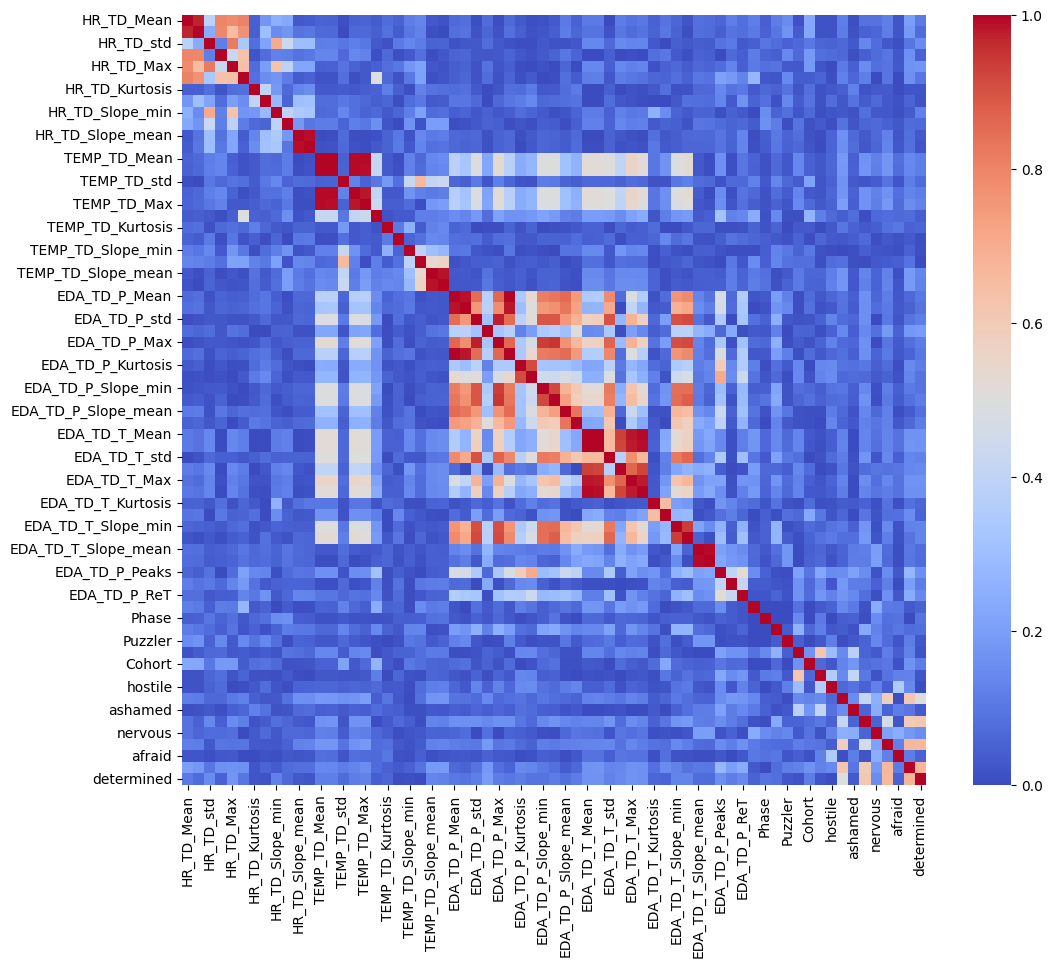

In [4]:
# Do correlation matrix and exclude highly correlated features
correlation = data.corr()
correlation = correlation.abs()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.show()


In [5]:
# Print correlation pairs that have a correlation higher than 0.9
correlation_pairs = correlation.unstack()
correlation_pairs = correlation_pairs[correlation_pairs > 0.9]
correlation_pairs = correlation_pairs[correlation_pairs < 1]
correlation_pairs = correlation_pairs.drop_duplicates()

for pair in correlation_pairs.index:
    print(pair, correlation_pairs[pair])

('HR_TD_Mean', 'HR_TD_Median') 0.9711090179326857
('HR_TD_Slope_mean', 'HR_TD_Slope') 0.988483580720514
('TEMP_TD_Mean', 'TEMP_TD_Median') 0.999642064136751
('TEMP_TD_Mean', 'TEMP_TD_Min') 0.9957182390665097
('TEMP_TD_Mean', 'TEMP_TD_Max') 0.9937968166938452
('TEMP_TD_Median', 'TEMP_TD_Min') 0.9950233585796113
('TEMP_TD_Median', 'TEMP_TD_Max') 0.9921187756697973
('TEMP_TD_Min', 'TEMP_TD_Max') 0.9823554279207789
('TEMP_TD_Slope_mean', 'TEMP_TD_Slope') 0.9862403216638368
('EDA_TD_P_Mean', 'EDA_TD_P_Median') 0.9849312638552072
('EDA_TD_P_Mean', 'EDA_TD_P_AUC') 0.9986950689710232
('EDA_TD_P_Median', 'EDA_TD_P_AUC') 0.9830782502328376
('EDA_TD_P_std', 'EDA_TD_P_Max') 0.9729404018401826
('EDA_TD_P_std', 'EDA_TD_T_Slope_min') 0.9033461816036368
('EDA_TD_P_std', 'EDA_TD_T_Slope_max') 0.915138069800837
('EDA_TD_P_Max', 'EDA_TD_P_Slope_min') 0.935288449231538
('EDA_TD_P_Max', 'EDA_TD_P_Slope_max') 0.9483760188161984
('EDA_TD_P_Max', 'EDA_TD_T_Slope_min') 0.9073653754199978
('EDA_TD_P_Max', 'EDA_

In [6]:
# Not including highly correlated features (e.g. mean and median) and only focusing on physiological features

features = ['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_std',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_std',
       'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT'
]

In [7]:
# All physiological features
non_physiological = ['Phase', 'Round',
 'Individual',
 'Puzzler',
 'Frustrated',
 'Cohort',
 'upset',
 'hostile',
 'alert',
 'ashamed',
 'inspired',
 'nervous',
 'attentive',
 'afraid',
 'active',
 'determined'
]

# get all physiological features
features = [col for col in data.columns if col not in non_physiological]

In [9]:
# Means
features = ['HR_TD_Mean', 'TEMP_TD_Mean', 'EDA_TD_P_Mean', 'EDA_TD_T_Mean']

# STD
#features = ['HR_TD_std', 'TEMP_TD_std', 'EDA_TD_P_std', 'EDA_TD_T_std']

# Means and STDs
#features = ['HR_TD_Mean', 'TEMP_TD_Mean', 'EDA_TD_P_Mean', 'EDA_TD_T_Mean', 'HR_TD_std', 'TEMP_TD_std', 'EDA_TD_P_std', 'EDA_TD_T_std']

Emotions:

In [10]:
# DO PCA
DO_PCA = False



X_phase1_r1 = data[(data["Phase"] == 1) & (data["Round"].isin([1]))][features]
X_phase1_r2 = data[(data["Phase"] == 1) & (data["Round"].isin([2]))][features]
X_phase1_r3 = data[(data["Phase"] == 1) & (data["Round"].isin([3]))][features]
X_phase1_r4 = data[(data["Phase"] == 1) & (data["Round"].isin([4]))][features]
X_phase2_r1 = data[(data["Phase"] == 2) & (data["Round"].isin([1]))][features]
X_phase2_r2 = data[(data["Phase"] == 2) & (data["Round"].isin([2]))][features]
X_phase2_r3 = data[(data["Phase"] == 2) & (data["Round"].isin([3]))][features]
X_phase2_r4 = data[(data["Phase"] == 2) & (data["Round"].isin([4]))][features]
X_phase3_r1 = data[(data["Phase"] == 3) & (data["Round"].isin([1]))][features]
X_phase3_r2 = data[(data["Phase"] == 3) & (data["Round"].isin([2]))][features]
X_phase3_r3 = data[(data["Phase"] == 3) & (data["Round"].isin([3]))][features]
X_phase3_r4 = data[(data["Phase"] == 3) & (data["Round"].isin([4]))][features]

data_subsets = [
    X_phase1_r1, X_phase1_r2, X_phase1_r3, X_phase1_r4,
    X_phase2_r1, X_phase2_r2, X_phase2_r3, X_phase2_r4,
    X_phase3_r1, X_phase3_r2, X_phase3_r3, X_phase3_r4
]

# Names for labeling in the plot
subset_names = [
    'Phase 1 R1', 'Phase 1 R2', 'Phase 1 R3', 'Phase 1 R4',
    'Phase 2 R1', 'Phase 2 R2', 'Phase 2 R3', 'Phase 2 R4',
    'Phase 3 R1', 'Phase 3 R2', 'Phase 3 R3', 'Phase 3 R4'
]

# Initialize the scaler
scaler = StandardScaler()

# Scale all data subsets at once
scaled_data_subsets = [scaler.fit_transform(subset) for subset in data_subsets]


# Apply PCA
from sklearn.decomposition import PCA

# Initialize PCA

if DO_PCA:
    pca = PCA(n_components=1)

    # Apply PCA to the scaled data USING ALL PHYSIOLOGICAL FEATURES
    pca_data_subsets = [pca.fit_transform(scaled_subset) for scaled_subset in scaled_data_subsets]

    # examine the explained variance ratio

    for i, pca_data in enumerate(pca_data_subsets):
        print(f"{subset_names[i]} explained variance ratio: {np.sum(pca.explained_variance_ratio_)}")

    scaled_data_subsets = pca_data_subsets


# TODO:
- [X] Find the best number of clusters for each phase separately (using the elbow method, silhouette score, gap statistic)
- [X] Use Rand index to compare the clustering results between the phases to check if participants are clustered similarly in all phases
- [ ] Use contingency tables or cross-tabulations to compare cluster memberships. (or flow charts) 

- [ ] Integration with Self-reported Emotional Scores:
- [ ] Analyse clusters with average scores of emotions like frustration, alertness, etc., to validate or explore the physiological findings.
- [ ] Analyse clusters with mean physiological features to understand the physiological differences between clusters

## Choosing the best number of clusters and features


### Feature selection 

- we are concerned only by the physiological features as we are using them for clustering

We try:
- All features (physiological)
- Features with correlation below 0.9
- Just the means
- Just the standard deviations
- Just the means and standard deviations
- PCA with 90% variance explained
- PCA of first 2 components

To compare the different clustering results, we will use the silhouette score that ranges from -1 to 1, where 1 indicates that the clusters are well apart from each other and clearly distinguished. In other words, it tells us how similar an object is to its cluster compared to other clusters. Which tells the quality of the clustering.
- We look at the average silhouette score for each phase and round for the entire cluster examined (e.g. average of 25 clusters we examined)

#### All features

```python
Average silhouette score for Phase 1 R1: 0.05302450622600698
Average silhouette score for Phase 1 R2: 0.07357630371704543
Average silhouette score for Phase 1 R3: 0.1395895334825941
Average silhouette score for Phase 1 R4: 0.08248076901710998
Average silhouette score for Phase 2 R1: 0.05801957163853341
Average silhouette score for Phase 2 R2: 0.08646558354132901
Average silhouette score for Phase 2 R3: 0.1289929643144827
Average silhouette score for Phase 2 R4: 0.08207567710143586
Average silhouette score for Phase 3 R1: 0.08590581432570514
Average silhouette score for Phase 3 R2: 0.09566387293891616
Average silhouette score for Phase 3 R3: 0.11654302831266188
Average silhouette score for Phase 3 R4: 0.07010102035104812
Overall average silhouette score: 0.08936988708057247
```

#### All features with correlation below 0.9

```python
Average silhouette score for Phase 1 R1: 0.06645466814789482
Average silhouette score for Phase 1 R2: 0.08568945732728499
Average silhouette score for Phase 1 R3: 0.12869225626569383
Average silhouette score for Phase 1 R4: 0.06090224912489375
Average silhouette score for Phase 2 R1: 0.058917188092091254
Average silhouette score for Phase 2 R2: 0.04416680938200574
Average silhouette score for Phase 2 R3: 0.13272636543425362
Average silhouette score for Phase 2 R4: 0.06863852779026502
Average silhouette score for Phase 3 R1: 0.0614699328940456
Average silhouette score for Phase 3 R2: 0.06881353038382886
Average silhouette score for Phase 3 R3: 0.11162328577650475
Average silhouette score for Phase 3 R4: 0.039207175612467886
Overall average silhouette score: 0.07727512051926917
```
#### Just the means

```python
Average silhouette score for Phase 1 R1: 0.24514943459332458
Average silhouette score for Phase 1 R2: 0.20857618461150929
Average silhouette score for Phase 1 R3: 0.2904887824323392
Average silhouette score for Phase 1 R4: 0.22854086545757057
Average silhouette score for Phase 2 R1: 0.22405204234949383
Average silhouette score for Phase 2 R2: 0.17625782884982663
Average silhouette score for Phase 2 R3: 0.24719452450670962
Average silhouette score for Phase 2 R4: 0.25440802961340825
Average silhouette score for Phase 3 R1: 0.2741429052965658
Average silhouette score for Phase 3 R2: 0.26565741676966476
Average silhouette score for Phase 3 R3: 0.2926823328029167
Average silhouette score for Phase 3 R4: 0.24078329040193538
Overall average silhouette score: 0.24566113647377205
```

#### Just the standard deviations

```python
Average silhouette score for Phase 1 R1: 0.28132042025173165
Average silhouette score for Phase 1 R2: 0.20580832229709092
Average silhouette score for Phase 1 R3: 0.27249952854904436
Average silhouette score for Phase 1 R4: 0.2577526427797937
Average silhouette score for Phase 2 R1: 0.1953498682280569
Average silhouette score for Phase 2 R2: 0.26060681903887456
Average silhouette score for Phase 2 R3: 0.25188522745139164
Average silhouette score for Phase 2 R4: 0.19837242075820263
Average silhouette score for Phase 3 R1: 0.26018061237178003
Average silhouette score for Phase 3 R2: 0.2454539165068451
Average silhouette score for Phase 3 R3: 0.29907028348540327
Average silhouette score for Phase 3 R4: 0.20865856544492922
Overall average silhouette score: 0.24474655226359532
```

#### Just the means and standard deviations

```python
Average silhouette score for Phase 1 R1: 0.15351286472381562
Average silhouette score for Phase 1 R2: 0.16326238590048314
Average silhouette score for Phase 1 R3: 0.21683252419918517
Average silhouette score for Phase 1 R4: 0.19283323318743606
Average silhouette score for Phase 2 R1: 0.14955393199201292
Average silhouette score for Phase 2 R2: 0.14385851567885768
Average silhouette score for Phase 2 R3: 0.1891770060716853
Average silhouette score for Phase 2 R4: 0.14960376060710096
Average silhouette score for Phase 3 R1: 0.16337526323055146
Average silhouette score for Phase 3 R2: 0.1670175729582435
Average silhouette score for Phase 3 R3: 0.23746248030626335
Average silhouette score for Phase 3 R4: 0.1790600635760712
Overall average silhouette score: 0.17546246686930886
```

#### PCA with 90% variance explained

```python
Average silhouette score for Phase 1 R1: 0.07199648303720395
Average silhouette score for Phase 1 R2: 0.10565698852830825
Average silhouette score for Phase 1 R3: 0.15560962924939606
Average silhouette score for Phase 1 R4: 0.11000782693856659
Average silhouette score for Phase 2 R1: 0.07624181517210261
Average silhouette score for Phase 2 R2: 0.12465654798430363
Average silhouette score for Phase 2 R3: 0.14517061247544405
Average silhouette score for Phase 2 R4: 0.10273906392119088
Average silhouette score for Phase 3 R1: 0.13131028590155425
Average silhouette score for Phase 3 R2: 0.1260265519754854
Average silhouette score for Phase 3 R3: 0.17359166013868152
Average silhouette score for Phase 3 R4: 0.10161045193983233
Overall average silhouette score: 0.11871815977183914
```

#### PCA of first 2 components

```python
Average silhouette score for Phase 1 R1: 0.26573223677689967
Average silhouette score for Phase 1 R2: 0.26705931794881593
Average silhouette score for Phase 1 R3: 0.3347362214639154
Average silhouette score for Phase 1 R4: 0.291995487976424
Average silhouette score for Phase 2 R1: 0.34768314665621497
Average silhouette score for Phase 2 R2: 0.3174039018852281
Average silhouette score for Phase 2 R3: 0.32172406554816774
Average silhouette score for Phase 2 R4: 0.28066436909416614
Average silhouette score for Phase 3 R1: 0.33189268125240273
Average silhouette score for Phase 3 R2: 0.2862563215410099
Average silhouette score for Phase 3 R3: 0.3509217037565043
Average silhouette score for Phase 3 R4: 0.24425337988824988
Overall average silhouette score: 0.3033602361489999
```

### Elbow Method

- Elbow method shows us that for these phases and rounds the best amount of clusters is:
- Phase 1, Round 1: 5
- Phase 1, Round 2: 5
- Phase 1, Round 3: 7
- Phase 1, Round 4: 6
- Phase 2, Round 1: 4
- Phase 2, Round 2: 4
- Phase 2, Round 3: 4
- Phase 2, Round 4: 8
- Phase 3, Round 1: 7
- Phase 3, Round 2: 6
- Phase 3, Round 3: 6
- Phase 3, Round 4: 5

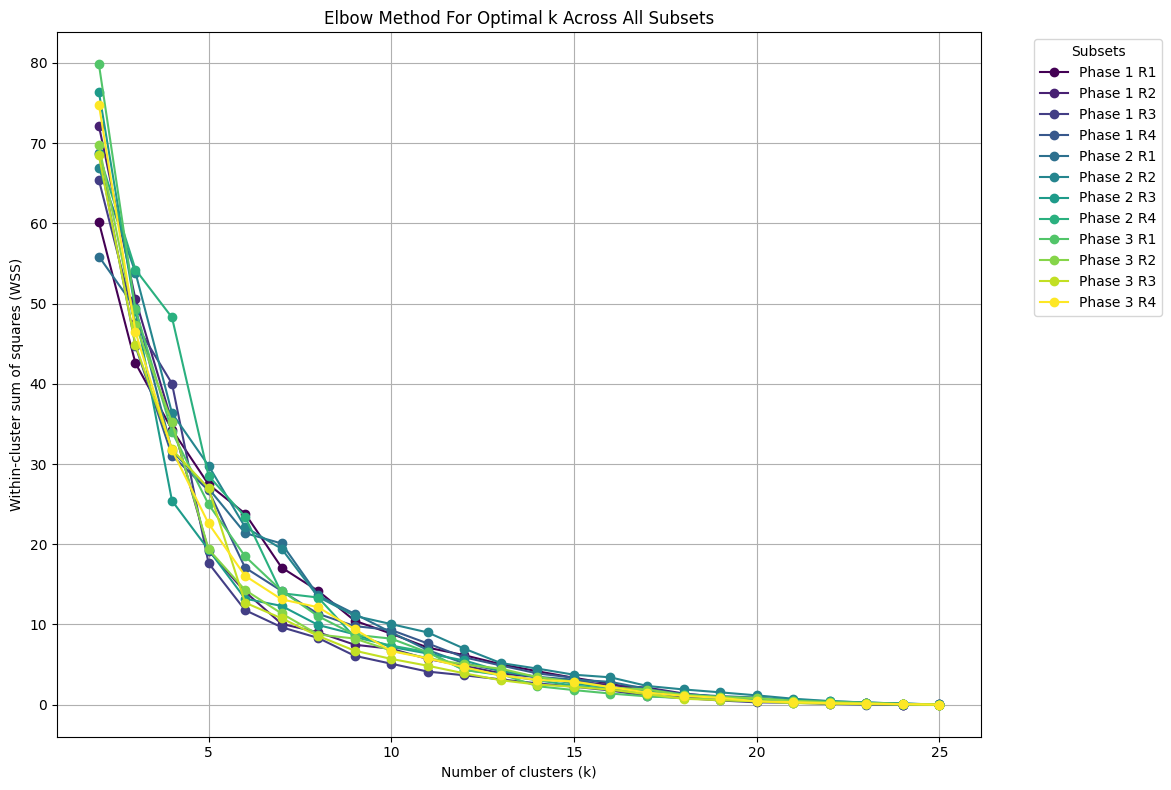

In [12]:
# Define a function to calculate WSS for a range of k values
def calculate_wss(data):
    wss = []
    for k in range(2, 26):
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(data)
        wss.append(kmeans.inertia_)
    return wss

# Prepare the figure for plotting
plt.figure(figsize=(14, 8))

# Colors for each line
colors = plt.cm.viridis(np.linspace(0, 1, len(scaled_data_subsets)))
#print(scaled_data_subsets)

# Calculate and plot WSS for each scaled subset
for i, scaled_data in enumerate(scaled_data_subsets):
    # Calculate WSS
    wss = calculate_wss(scaled_data)
    
    # Plot WSS
    plt.plot(range(2, 26), wss, marker='o', linestyle='-', color=colors[i], label=subset_names[i])


# Add plot details
plt.title('Elbow Method For Optimal k Across All Subsets')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WSS)')
plt.legend(title='Subsets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0,0,0.85,1])  # Adjust layout to make room for the legend

plt.show()


Silhoutte scores for the different phases:

Note that all the silhouette scores are quite poor so we can't conclude anything from it.

Average silhouette score for Phase 1 R1: 0.22423015065942584
Average silhouette score for Phase 1 R2: 0.19795462264947097
Average silhouette score for Phase 1 R3: 0.2780109276204609
Average silhouette score for Phase 1 R4: 0.2310527973940216
Average silhouette score for Phase 2 R1: 0.22339750300940278
Average silhouette score for Phase 2 R2: 0.1923034479478334
Average silhouette score for Phase 2 R3: 0.24723079545666823
Average silhouette score for Phase 2 R4: 0.2433129775549027
Average silhouette score for Phase 3 R1: 0.27058225192054325
Average silhouette score for Phase 3 R2: 0.24083936166576994
Average silhouette score for Phase 3 R3: 0.276906996486258
Average silhouette score for Phase 3 R4: 0.24015009946905028
Overall average silhouette score: 0.23883099431948399


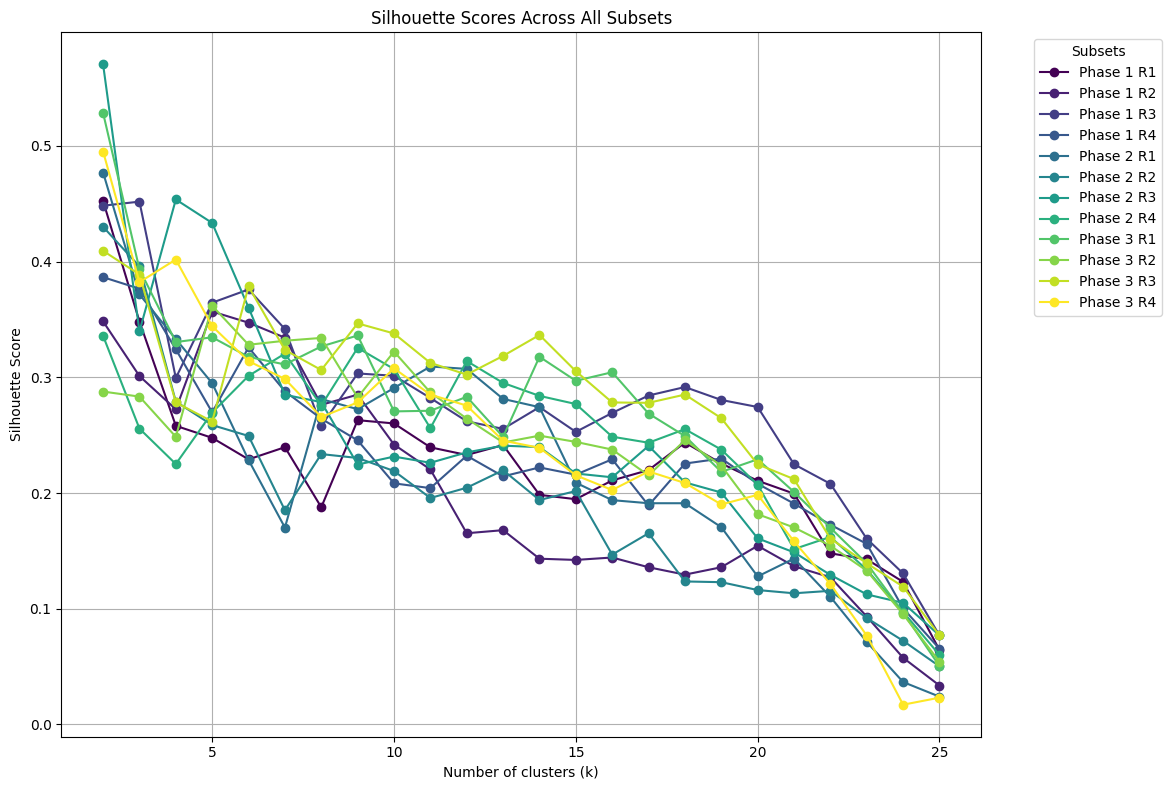

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming scaled_data_subsets and subset_names are already defined as in previous context

# Range of k values to try
k_values = range(2, 26)

# Define a function to calculate silhouette scores for a range of k values
def calculate_silhouette_scores(data):
    scores = []
    for k in k_values:
        # Check if dataset has at least k samples
        if len(data) >= k:
            kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(data)
            score = silhouette_score(data, kmeans.labels_)
            scores.append(score)
        else:
            scores.append(None)  # Append None if not enough samples for k clusters
    return scores

# Prepare the figure for plotting
plt.figure(figsize=(14, 8))

# Colors for each line
colors = plt.cm.viridis(np.linspace(0, 1, len(scaled_data_subsets)))

# Calculate and plot silhouette scores for each scaled subset
overall_scores = []
for i, scaled_data in enumerate(scaled_data_subsets):
    # Calculate silhouette scores
    scores = calculate_silhouette_scores(scaled_data)
    
    # Plot silhouette scores
    plt.plot([k for k in k_values if scores[k-2] is not None],
            [score for score in scores if score is not None],
            marker='o', linestyle='-', color=colors[i], label=subset_names[i])

    # print average silhouette score
    print(f"Average silhouette score for {subset_names[i]}: {np.mean(scores)}")
    overall_scores.append(np.mean(scores))

# Overall average silhouette score
print(f"Overall average silhouette score: {np.mean(overall_scores)}")

# Add plot details
plt.title('Silhouette Scores Across All Subsets')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend(title='Subsets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0,0,0.85,1])  # Adjust layout to make room for the legend

plt.show()


Rand Index to compare clusterings (Using k from Gap statistic):

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

# Define the list of data subsets grouped by phase and round
data_subsets = {
    'Phase 1 Round 1': X_phase1_r1, 'Phase 1 Round 2': X_phase1_r2,
    'Phase 1 Round 3': X_phase1_r3, 'Phase 1 Round 4': X_phase1_r4,
    'Phase 2 Round 1': X_phase2_r1, 'Phase 2 Round 2': X_phase2_r2,
    'Phase 2 Round 3': X_phase2_r3, 'Phase 2 Round 4': X_phase2_r4,
    'Phase 3 Round 1': X_phase3_r1, 'Phase 3 Round 2': X_phase3_r2,
    'Phase 3 Round 3': X_phase3_r3, 'Phase 3 Round 4': X_phase3_r4
}

# Initialize a scaler
scaler = StandardScaler()

# Scale each subset and store in a new dictionary for further analysis
scaled_data_subsets = {key: scaler.fit_transform(data) for key, data in data_subsets.items()}

n_clusters = 6
kmeans_models = {}
labels = {}

# Function to perform clustering
def cluster_data(key, scaled_data):
    kmeans = KMeans(n_init='auto', n_clusters=n_clusters, random_state=0).fit(scaled_data)
    kmeans_models[key] = kmeans
    labels[key] = kmeans.labels_
    print(f'Labels for {key}: {labels[key]}')

# Cluster each scaled subset
for key, scaled_data in scaled_data_subsets.items():
    cluster_data(key, scaled_data)

# Function to calculate and print ARI between two phases and rounds
def calculate_and_print_ari(key1, key2):
    print(key1)
    ari = adjusted_rand_score(labels[key1], labels[key2])
    nmi = NMI(labels[key1], labels[key2])
    print(100*'-')
    print(f"Adjusted Rand Index between {key1} and {key2}: {ari}")#
    print(f"Normalized Mutual Information between {key1} and {key2}: {nmi}")
    


# Calculate ARIs for each round across all phase combinations
for round_num in range(1, 5):
    phase_keys = [f'Phase {i} Round {round_num}' for i in range(1, 4)]
    calculate_and_print_ari(phase_keys[0], phase_keys[1])
    calculate_and_print_ari(phase_keys[0], phase_keys[2])
    calculate_and_print_ari(phase_keys[1], phase_keys[2])

Labels for Phase 1 Round 1: [3 4 3 0 0 2 4 3 3 0 0 3 0 2 5 4 4 1 1 1 0 2 2 3 0 2]
Labels for Phase 1 Round 2: [5 3 4 0 3 3 3 5 3 5 0 3 0 0 3 3 3 1 2 1 0 0 4 0 0 4]
Labels for Phase 1 Round 3: [0 3 3 3 1 5 3 0 3 0 3 3 0 0 1 1 1 1 4 1 3 3 2 0 3 2]
Labels for Phase 1 Round 4: [0 0 3 3 3 3 3 0 3 5 1 3 0 0 4 1 3 1 2 1 0 5 3 0 0 5]
Labels for Phase 2 Round 1: [0 5 4 0 5 3 5 0 0 4 0 0 0 5 2 3 3 2 2 1 5 4 4 0 5 4]
Labels for Phase 2 Round 2: [0 4 4 3 3 3 4 0 3 0 4 3 0 3 2 2 3 2 5 1 4 3 3 0 3 3]
Labels for Phase 2 Round 3: [0 5 3 5 2 2 5 0 3 0 5 5 0 0 3 2 3 2 1 2 5 0 3 0 5 4]
Labels for Phase 2 Round 4: [5 3 3 1 1 1 3 2 3 2 3 3 5 5 1 1 1 1 4 1 2 5 0 2 3 5]
Labels for Phase 3 Round 1: [0 3 5 0 0 3 3 0 3 0 0 0 0 3 2 2 2 4 1 2 0 3 5 0 0 5]
Labels for Phase 3 Round 2: [0 5 3 5 5 1 1 0 3 0 5 1 0 0 4 1 1 4 2 1 5 3 3 0 5 3]
Labels for Phase 3 Round 3: [0 3 5 4 1 4 3 0 3 0 3 3 0 0 3 4 3 1 2 1 0 0 5 0 3 5]
Labels for Phase 3 Round 4: [0 0 5 2 2 3 5 0 3 0 5 5 0 0 2 2 3 2 1 2 0 5 4 0 5 5]
Phase 1 Round 1


Emotional analysis:

In [26]:
# Assigning cluster labels to the 'data' DataFrame
def assign_labels(data, labels, phase, round_num):
    # Define the condition to select the correct segment of 'data'
    condition = (data["Phase"] == phase) & (data["Round"].isin([round_num]))
    # Assign labels using the same condition used for segmenting during clustering
    data.loc[condition, 'Cluster'] = labels[f'Phase {phase} Round {round_num}']

# Use the function to assign labels for all phases and rounds
for phase in range(1, 4):
    for round_num in range(1, 5): 
        assign_labels(data, labels, phase, round_num)


In [27]:
# Assuming 'data' has columns 'Phase', 'Round', and 'Cluster' properly set up
# Filter the DataFrame to select only the rows for Phase 1 and Round 1
phase1_round1_data = data[(data['Phase'] == 1) & (data['Round'] == 1)]

# Print the cluster labels for Phase 1, Round 1
print("Cluster labels for Phase 1, Round 1:")
print(phase1_round1_data['Cluster'])




Cluster labels for Phase 1, Round 1:
11     3.0
23     4.0
35     3.0
47     0.0
59     0.0
71     2.0
83     4.0
95     3.0
107    3.0
119    0.0
131    0.0
143    3.0
155    0.0
167    2.0
179    5.0
191    4.0
203    4.0
215    1.0
227    1.0
239    1.0
251    0.0
263    2.0
275    2.0
287    3.0
299    0.0
311    2.0
Name: Cluster, dtype: float64


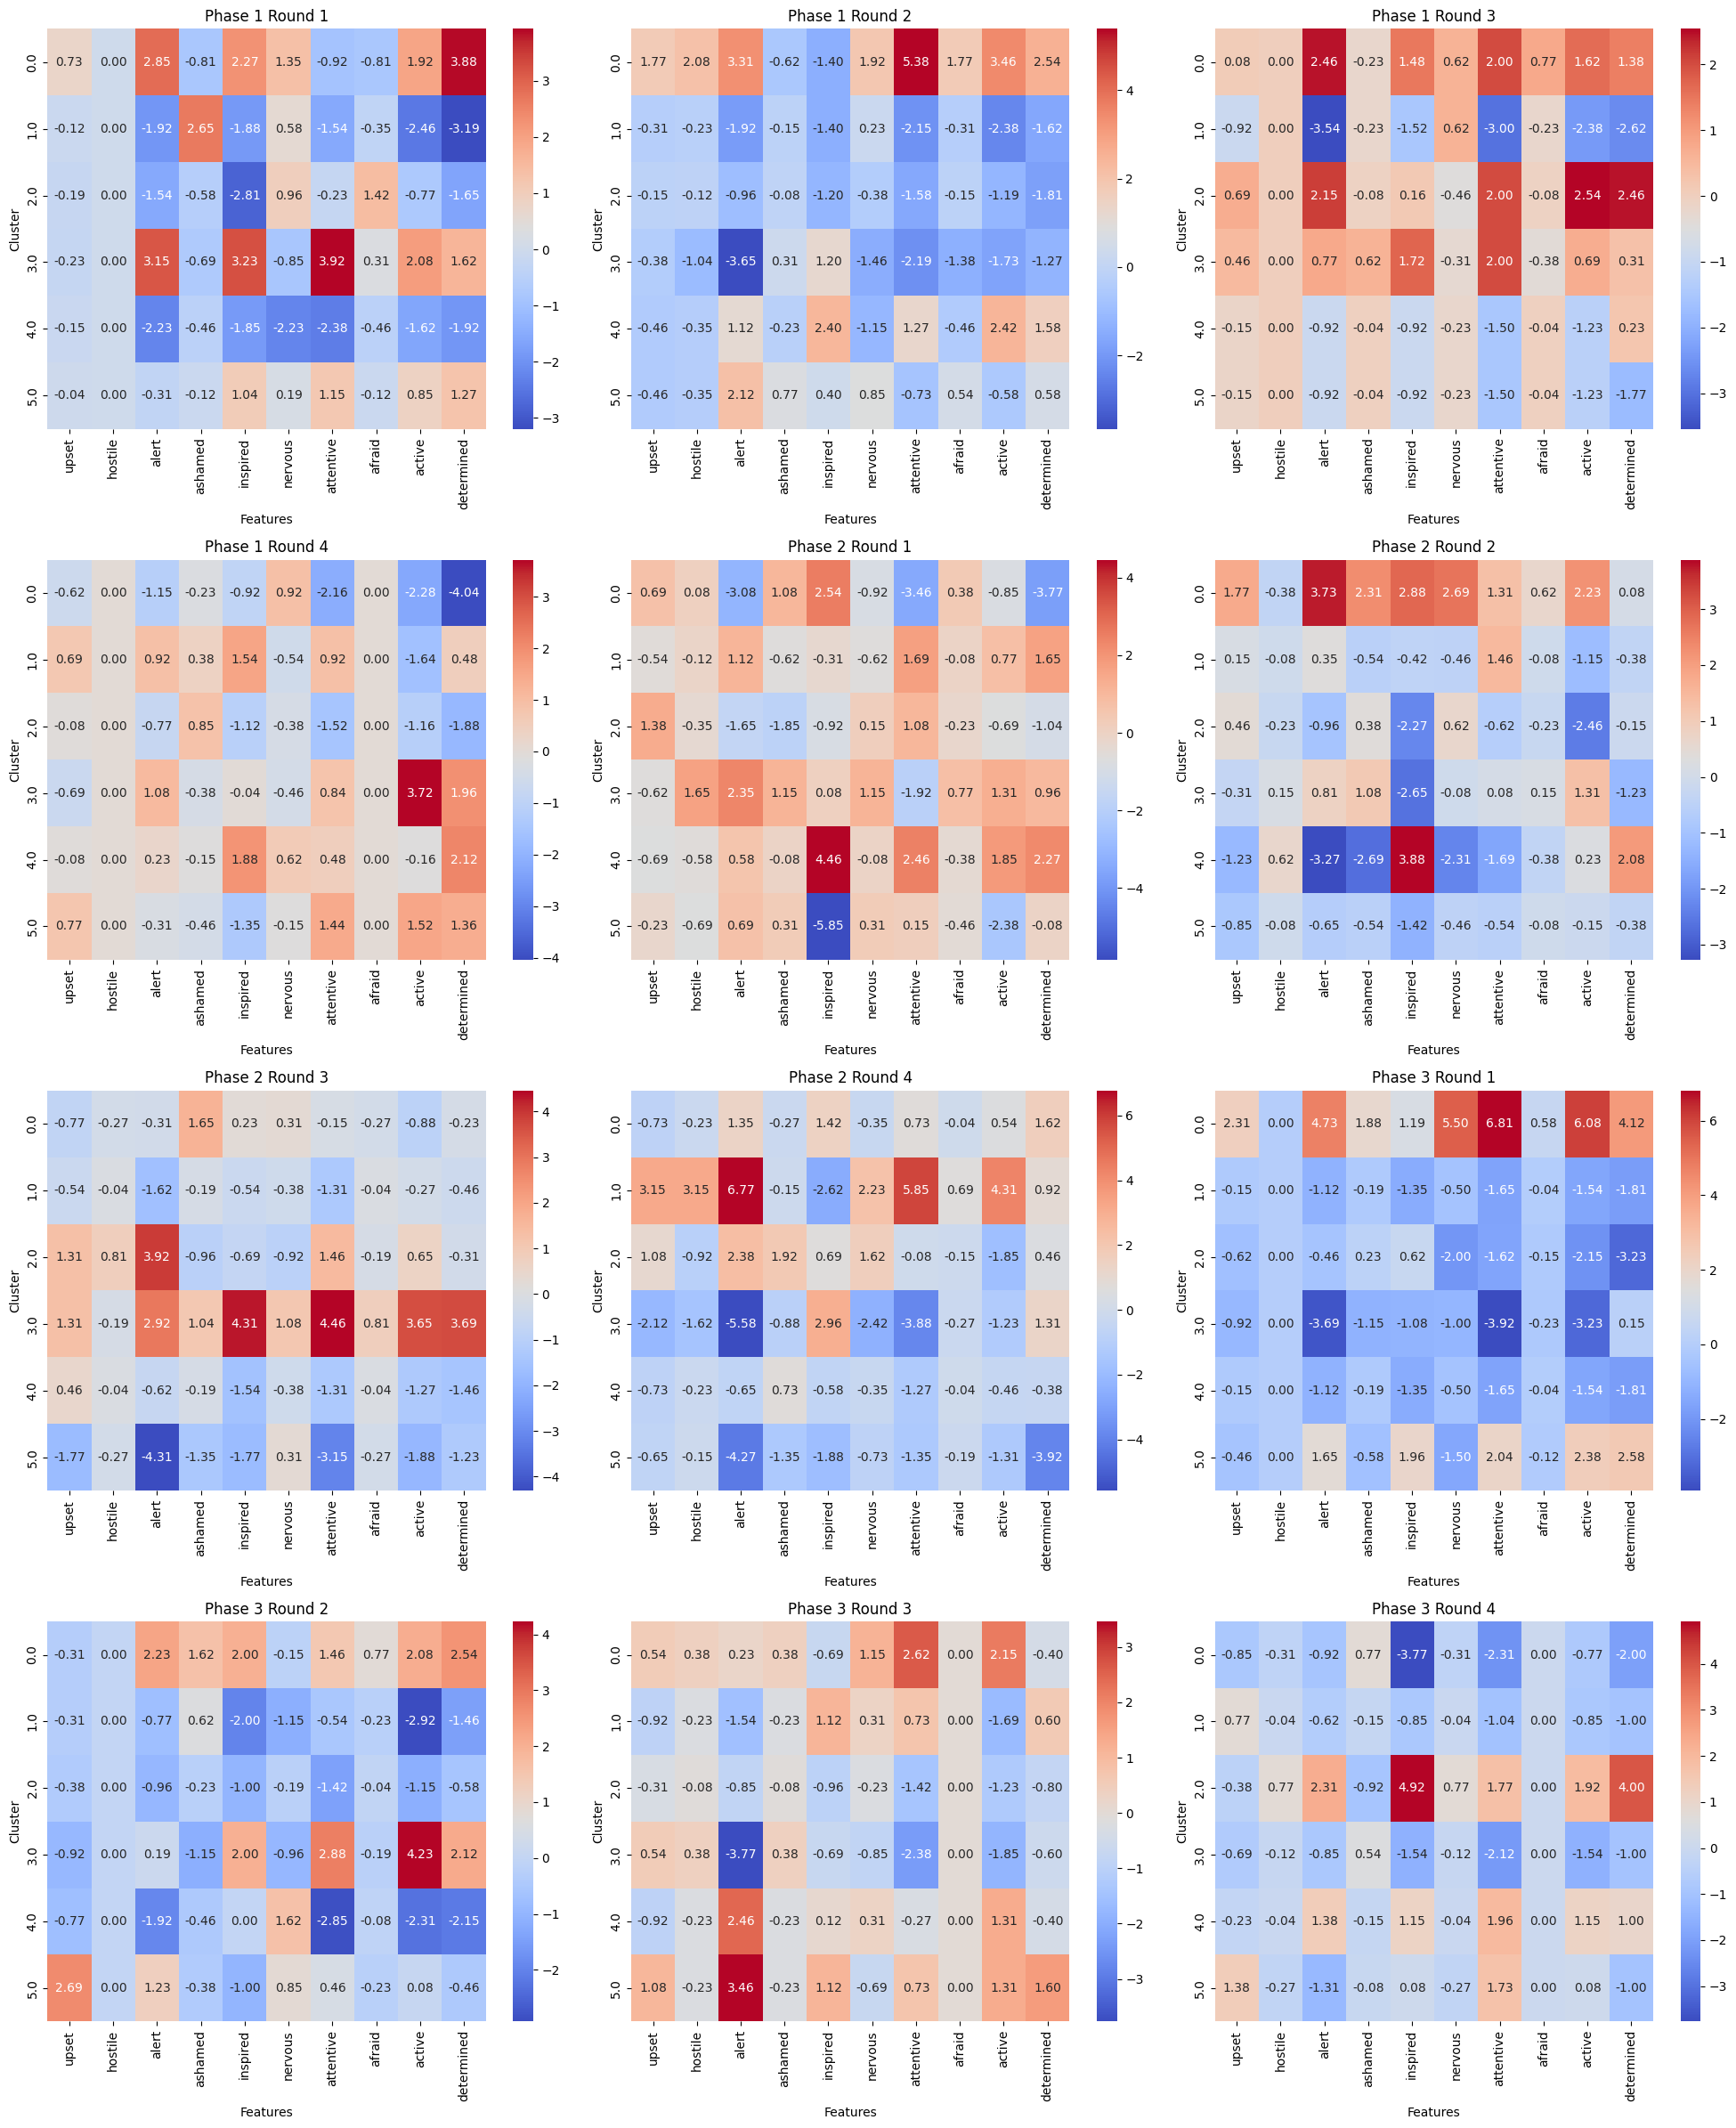

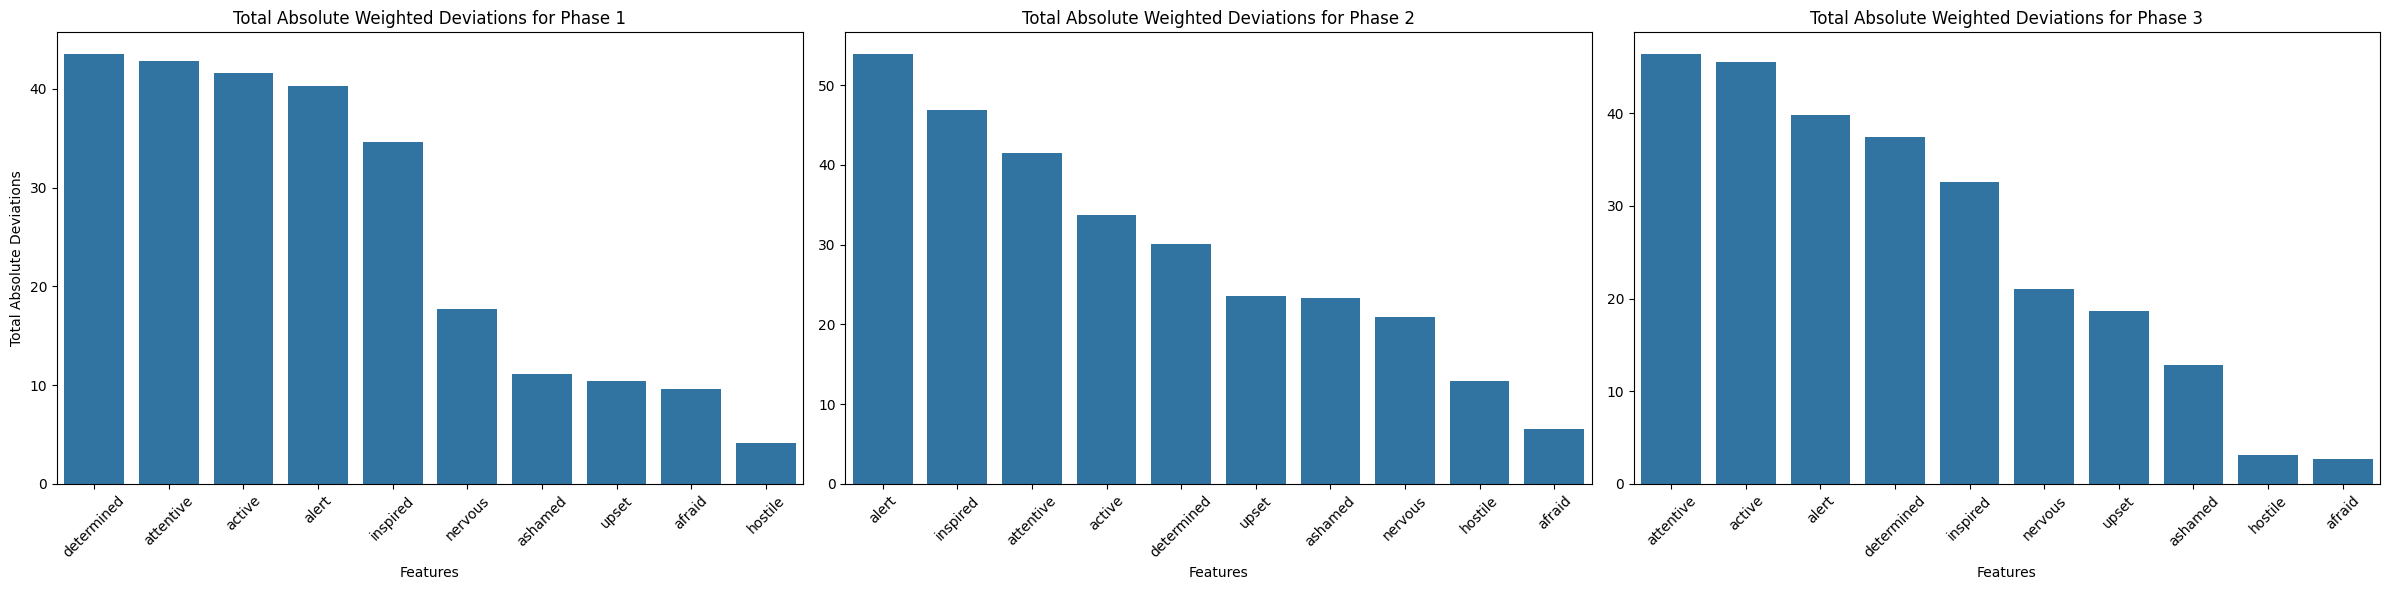

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of specific features to analyze
features = [
    'upset', 'hostile', 'alert', 'ashamed', 'inspired',
    'nervous', 'attentive', 'afraid', 'active', 'determined'
]

all_deviations = {}
phase_deviations = {phase: pd.DataFrame(0.0, index=[0], columns=features) for phase in range(1, 4)}


plt.figure(figsize=(20, 24))  

subplot_index = 1  


for phase in range(1, 4):  
    for round_num in range(1, 5):  
        
        condition = (data['Phase'] == phase) & (data['Round'] == round_num)
        filtered_data = data.loc[condition, features + ['Cluster']]

        
        global_means = filtered_data[features].mean(skipna=True)

        # Fill NaNs with global means
        filtered_data[features] = filtered_data[features].fillna(global_means)

        
        cluster_means = filtered_data.groupby('Cluster')[features].mean()

        
        cluster_sizes = filtered_data['Cluster'].value_counts()

        
        deviations = cluster_means - global_means

        
        weighted_deviations = deviations.mul(cluster_sizes, axis=0)

        
        abs_weighted_deviations = weighted_deviations.abs()

       
        abs_sum = abs_weighted_deviations.sum()
        for feature in features:
            if feature not in abs_sum:
                abs_sum[feature] = 0  

        
        phase_deviations[phase].iloc[0] += abs_sum.astype(float)

       
        plt.subplot(4, 3, subplot_index) 
        sns.heatmap(weighted_deviations, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Phase {phase} Round {round_num}')
        plt.ylabel('Cluster')
        plt.xlabel('Features')

        subplot_index += 1  

plt.tight_layout()   
plt.show()

plt.figure(figsize=(24, 6))  # Adjust the width as needed

for i, phase in enumerate(phase_deviations, start=1):
    plt.subplot(1, 3, i)  
    sns.barplot(data=phase_deviations[phase].iloc[0].sort_values(ascending=False).reset_index(), x='index', y=0)
    plt.title(f'Total Absolute Weighted Deviations for Phase {phase}')
    plt.ylabel('Total Absolute Deviations' if i == 1 else '') 
    plt.xlabel('Features')
    plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()